<h1 style="text-align:center;">Cleanup Table S3 Contacts of Liu et al.</h1>

In [296]:
import os
import glob
import pandas as pd
import numpy as np
import re

from Bio.PDB import PDBList
from pathlib import Path
from Bio.PDB import PDBParser, NeighborSearch, PDBIO
from Bio.SeqUtils import seq1

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind


# Original Data

In [ ]:
# Path to your Excel file
excel_file = 'TableS3_contact.xlsx'

# Read all sheets into a dictionary
sheets_dict = pd.read_excel(excel_file, sheet_name=None)  # None loads all sheets

# Loop through each sheet and save as CSV
for sheet_name, df in sheets_dict.items():
    csv_filename = f"{sheet_name}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Saved {csv_filename}")


Saved TableS3A_contact_pMHC.csv
Saved TableS3B_contact_pep.csv


# Download PDB files

In [ ]:
def download_pdb(pdb_id, out_dir="pdbs"):
    """
    Download a PDB structure from RCSB.
    """
    pdb_id = pdb_id.lower()
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    try:
        pdbl = PDBList()
        raw_path = pdbl.retrieve_pdb_file(
            pdb_id,
            pdir=str(out_dir),
            file_format='pdb',
            overwrite=True
        )

        raw_path = Path(raw_path)
        clean_path = out_dir / f"{pdb_id}.pdb"
        raw_path.rename(clean_path)
    
    except Exception as e:
        print(f"[ERROR] Could not download {pdb_id}: {e}")
        return None


In [ ]:
df = pd.read_csv('TableS3A_contact_pMHC.csv')

outdir = 'pdbs' # directory for downloaded pdb files

for _, row in df.iterrows():
    # download PDB
    download_pdb(row.PDB, outdir)

Desired structure not found or download failed. '6r0e': HTTP Error 403: Forbidden
[ERROR] Could not download 6r0e: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'


# Annotate Chains

In [ ]:
def get_chain_sequences(pdb_file):
    """ 
    Create dictionary with all chain ids and the corresponding sequence. 
    """

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('tcr', pdb_file)
    
    chain_seqs = {}
    for chain in structure.get_chains():
        residues = [
            res for res in chain
            if res.id[0] == " "  # exclude hetero/water
        ]
        if not residues:
            continue
        
        seq = "".join(seq1(res.resname) for res in residues)
        chain_seqs[chain.id] = seq

    return chain_seqs

def find_epitope_chains(chain_seqs, epitope):
    return [
        cid for cid, seq in chain_seqs.items()
        if seq.upper() == epitope.upper()
    ]

def find_tcr_chains_by_cdr(chain_seqs, cdrs):
    hits = []
    for chain_id, seq in chain_seqs.items():
        n_hits = sum(cdr.lower() in seq.lower() for cdr in cdrs)
        if n_hits >= 2:
            hits.append(chain_id)
    return hits

def is_beta2m(seq):
    return 85 <= len(seq) <= 120

def find_mhci_alpha_from_beta2m(chain_seqs, beta2m_ids, excluded_ids):
    """
    Infer MHC-I alpha as remaining extracellular chains once beta2m is known.
    Returns only chain IDs (not seqs).
    """
    candidates = [
        (cid, seq)
        for cid, seq in chain_seqs.items()
        if cid not in excluded_ids
        and cid not in beta2m_ids
        and len(seq) >= 250
    ]
    # return only the chain IDs
    return [cid for cid, seq in candidates]


def chains_in_contact_count(structure, ref_chain_id, candidate_chain_ids, cutoff=8.0):
    """
    Helper to get chains with maximal contacts to epitope.
    """
    model = structure[0]
    ref_chain = model[ref_chain_id]
    # unfold all C-alpha atoms in the reference chain
    ref_atoms = [atom for res in ref_chain for atom in res if atom.get_name() == 'CA']

    # all C-alpha atoms in the structure
    all_atoms = [atom for chain in model for res in chain for atom in res if atom.get_name() == 'CA']
    ns = NeighborSearch(all_atoms)

    counts = {}
    for cid in candidate_chain_ids:
        candidate_atoms = [atom for res in model[cid] for atom in res if atom.get_name() == 'CA']
        contact_atoms = set()
        for atom in candidate_atoms:
            neighbors = ns.search(atom.coord, cutoff)
            # count only neighbors in ref_atoms
            if any(n in ref_atoms for n in neighbors):
                contact_atoms.add(atom)
        counts[cid] = len(contact_atoms)

    return counts


def min_ca_distance(structure, ref_chain_id, candidate_chain_ids):
    """
    Helper to get chains with minimum CA distance to epitope.
    """
    model = structure[0]
    ref_chain = model[ref_chain_id]

    ref_atoms = [
        atom for res in ref_chain
        for atom in res if atom.get_name() == 'CA'
    ]

    distances = {}
    for cid in candidate_chain_ids:
        candidate_atoms = [
            atom for res in model[cid]
            for atom in res if atom.get_name() == 'CA'
        ]
        if not candidate_atoms:
            distances[cid] = np.inf
            continue

        min_dist = min(
            np.linalg.norm(a.coord - b.coord)
            for a in candidate_atoms
            for b in ref_atoms
        )
        distances[cid] = min_dist

    return distances



def select_first_complex(structure, chain_seqs, row):
    # 1. pick epitope with lowest chain ID
    epitope_chains = find_epitope_chains(chain_seqs, row.epitope)
    if not epitope_chains:
        return {}
    epitope_chain = sorted(epitope_chains)[0]

    remaining = {cid: seq for cid, seq in chain_seqs.items() if cid != epitope_chain}

    # 2. pick TCR alpha/beta chains with most contacts (or smallest distance)
    tcr_alpha_candidates = find_tcr_chains_by_cdr(remaining, [row.CDR1A,row.CDR2A,row.CDR3A])
    tcr_beta_candidates  = find_tcr_chains_by_cdr(remaining, [row.CDR1B,row.CDR2B,row.CDR3B])
    
    tcr_alpha_counts = chains_in_contact_count(structure, epitope_chain, tcr_alpha_candidates)
    tcr_beta_counts  = chains_in_contact_count(structure, epitope_chain, tcr_beta_candidates)
    
    # TCR alpha
    if tcr_alpha_counts and max(tcr_alpha_counts.values()) > 0:
        tcr_alpha_chain = max(tcr_alpha_counts, key=tcr_alpha_counts.get)
    elif tcr_alpha_candidates:
        alpha_distances = min_ca_distance(structure, epitope_chain, tcr_alpha_candidates)
        tcr_alpha_chain = min(alpha_distances, key=alpha_distances.get)
    else:
        tcr_alpha_chain = None

    # TCR beta
    if tcr_beta_counts and max(tcr_beta_counts.values()) > 0:
        tcr_beta_chain = max(tcr_beta_counts, key=tcr_beta_counts.get)
    elif tcr_beta_candidates:
        beta_distances = min_ca_distance(structure, epitope_chain, tcr_beta_candidates)
        tcr_beta_chain = min(beta_distances, key=beta_distances.get)
    else:
        tcr_beta_chain = None


    used_ids = set(epitope_chains + tcr_alpha_candidates + tcr_beta_candidates)

    # 3. MHC chains: split remaining into candidates
    remaining = {cid: seq for cid, seq in remaining.items() if cid not in used_ids}

    # MHC-I: look for beta2m first
    beta2m_candidates = [cid for cid, seq in remaining.items() if is_beta2m(seq)]

    if beta2m_candidates:
        # MHC-I 
        mhci_alpha_candidates = [cid for cid in remaining if cid not in beta2m_candidates]
        
        # count contacts to epitope
        mhci_alpha_counts = chains_in_contact_count(structure, epitope_chain, mhci_alpha_candidates)
        mhci_alpha_chain = max(mhci_alpha_counts, key=mhci_alpha_counts.get)
        roles = {
            'epitope_chain': epitope_chain,
            'tcr_alpha_chain': tcr_alpha_chain,
            'tcr_beta_chain': tcr_beta_chain,
            'mhci_alpha_chain': mhci_alpha_chain,
        }
    else:
        # MHC-II
        mhcii_candidates = [cid for cid, seq in remaining.items()]

        if len(mhcii_candidates) < 2:
            return {}

        mhcii_counts = chains_in_contact_count(
            structure, epitope_chain, mhcii_candidates
        )

        # get the two chains with the highest contact counts
        top_two = sorted(
            mhcii_counts.items(),
            key=lambda x: x[1],
            reverse=True)[:2]

        # order those two by chain ID
        chain_ids = sorted(cid for cid, _ in top_two)
        mhcii_alpha, mhcii_beta = chain_ids[0], chain_ids[1]


        roles = {
            'epitope_chain': epitope_chain,
            'tcr_alpha_chain': tcr_alpha_chain,
            'tcr_beta_chain': tcr_beta_chain,
            'mhcii_alpha_chain': mhcii_alpha,
            'mhcii_beta_chain': mhcii_beta
        }

    return roles



In [ ]:
df = pd.read_csv('TableS3A_contact_pMHC.csv')
#test = ['6uon']
#df = df[df['PDB'].isin(test)]
outdir = 'pdbs' # directory for downloaded pdb files

for idx, row in df.iterrows():
    # get sequence for each chain
    pdb_file = os.path.join(outdir, f'{row.PDB}.pdb')

    if not os.path.exists(pdb_file):
        f'{pdb_file} does not exist.'
        continue

    chain_seqs = get_chain_sequences(pdb_file)
    structure = PDBParser(QUIET=True).get_structure('tcr', pdb_file)

    roles = select_first_complex(structure, chain_seqs, row)
    
    for col, cid in roles.items():
        df.at[idx, col] = cid

df = df.drop(columns=[col for col in df.columns if '_int' in col])
df.to_csv('chain_annotations.csv', index=False)
    

# Clean PDBs 

In [ ]:
from Bio.PDB import Structure, Model, Chain

def clean_chains(pdb_file, chain_mapping, out_file):
    """
    Keep only specified chains, rename them, and remove water/ions/ligands.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    # create new structure
    new_structure = Structure.Structure(structure.id)
    new_model = Model.Model(0)
    new_structure.add(new_model)

    model = structure[0]

    for old_chain_id, new_chain_id in chain_mapping.items():
        if old_chain_id not in model:
            continue  # skip missing chains
        old_chain = model[old_chain_id]

        # create new chain
        new_chain = Chain.Chain(new_chain_id)

        for residue in old_chain:
            # skip water and hetero residues
            if residue.id[0] != ' ':
                continue
            new_chain.add(residue.copy())

        new_model.add(new_chain)

    # save cleaned PDB
    io = PDBIO()
    io.set_structure(new_structure)
    io.save(out_file)


In [ ]:
df = pd.read_csv('chain_annotations.csv')

indir = 'pdbs'
outdir = 'pdbs_clean'
os.makedirs(outdir, exist_ok=True)

for idx, row in df.iterrows():
    # get sequence for each chain
    pdb_file = os.path.join(indir, f'{row.PDB}.pdb')

    if not os.path.exists(pdb_file):
        continue

    chain_mapping = {}
    if pd.notna(row.mhci_alpha_chain):
        chain_mapping[row.mhci_alpha_chain] = 'A'
    if pd.notna(row.mhcii_alpha_chain):
        chain_mapping[row.mhcii_alpha_chain] = 'A'
    if pd.notna(row.mhcii_beta_chain):
        chain_mapping[row.mhcii_beta_chain] = 'B'
    if pd.notna(row.epitope_chain):
        chain_mapping[row.epitope_chain] = 'C'
    if pd.notna(row.tcr_alpha_chain):
        chain_mapping[row.tcr_alpha_chain] = 'D'
    if pd.notna(row.tcr_beta_chain):
        chain_mapping[row.tcr_beta_chain] = 'E'

    clean_chains(pdb_file, chain_mapping, out_file=os.path.join(outdir, f'{row.PDB}.pdb'))

# Fix CDR3 sequences

In [86]:
def get_chain_sequence(pdb_file, chain_id):
    """
    Get sequence based on chain id.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("tcr", pdb_file)

    seq = []
    for res in structure[0][chain_id]: 
        seq.append(seq1(res.get_resname()))

    return "".join(seq)


def extract_cdr3(sequence, min_len=7, max_len=23):
    """
    Extract CDR3 using conserved C (start) and the F/W-GxG motif (end). Ensures min_len <= CDR3 length <= max_len.
    """
    # find all conserved C positions
    c_positions = [m.start() for m in re.finditer("C", sequence)]
    if not c_positions:
        return None

    # try Cs from last to first (most likely real CDR3 start)
    for c_pos in reversed(c_positions):
        subseq = sequence[c_pos:]

        # find all FGXG / WGXG motifs after this C
        matches = list(re.finditer(r"([FW])G.G", subseq))
        if not matches:
            continue

        # check motifs from LAST to FIRST
        for match in reversed(matches):
            end = c_pos + match.start(1) + 1
            cdr3 = sequence[c_pos:end]

            L = len(cdr3)
            if min_len <= L <= max_len:
                return cdr3

    return None


In [162]:
# fix CDR3 sequences
df = pd.read_csv('chain_annotations.csv')
indir = 'pdbs_clean'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()

fixed_rows = []
for pdb_file in pdbs:
    pdb_id = os.path.basename(pdb_file.split('.')[0])
    row = df[df["PDB"] == pdb_id]

    row = row.iloc[0].copy()

    # get TCR chains
    seq_a = get_chain_sequence(pdb_file, "D")
    seq_b = get_chain_sequence(pdb_file, "E")

    # extract correct CDRs
    cdr3a_fix = extract_cdr3(seq_a)
    cdr3b_fix = extract_cdr3(seq_b)

    row["CDR3A_fix"] = cdr3a_fix
    row["CDR3B_fix"] = cdr3b_fix

    if (cdr3a_fix is None) | (cdr3b_fix is None):
        print(f'Error: CDR3 not found for PDB id. {pdb_id}')
        continue

    fixed_rows.append(row)

df_fixed = pd.DataFrame(fixed_rows)
df_fixed['CDR3A_fix_short'] = df_fixed['CDR3A_fix'].str[1:-1]
df_fixed['CDR3B_fix_short'] = df_fixed['CDR3B_fix'].str[1:-1]
df_fixed.to_csv('chain_annotations_cdr3_fixed.csv', index=False)
df_fixed

Error: CDR3 not found for PDB id. 1ymm
Error: CDR3 not found for PDB id. 3vxu


,PDB,epitope,CDR1A,CDR2A,CDR3A,CDR1B,CDR2B,CDR3B,TRAV,TRAJ,...,epitope_chain,tcr_alpha_chain,tcr_beta_chain,mhci_alpha_chain,mhcii_alpha_chain,mhcii_beta_chain,CDR3A_fix,CDR3B_fix,CDR3A_fix_short,CDR3B_fix_short
0,1ao7,LLFGYPVYV,drgSqs,IysnGD,AVttdswgKLQ,MNHeY,SVGAGI,ASrPglaggrpEQY,TRAV12-2,TRAJ24,...,C,D,E,A,NaN,NaN,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,AVTTDSWGKLQ,ASRPGLAGGRPEQY
1,1bd2,LLFGYPVYV,NsmFdy,IssiKDK,AAmegaqkLV,MNHEY,SVGAGi,ASSypgggFyEQY,TRAV29/DV5,TRAJ54,...,C,D,E,A,NaN,NaN,CAAMEGAQKLVF,CASSYPGGGFYEQYF,AAMEGAQKLV,ASSYPGGGFYEQY
110,1fyt,PKYVKQNTLKLAT,SsvpPy,YtsaATLV,AVSeSpfGnekLT,mdhen,SydVKm,ASSstglpYGYT,TRAV8-4,TRAJ48,...,C,D,E,NaN,A,B,CAVSESPFGNEKLTF,CASSSTGLPYGYTF,AVSESPFGNEKLT,ASSSTGLPYGYT
2,1mi5,FLRGRAYGL,TIsgtDy,gltsN,ILPlaggstyGKLT,SGHvs,FqneAQ,ASSlgqayEQY,TRAV26-2,TRAJ52,...,C,D,E,A,NaN,NaN,CILPLAGGTSYGKLTF,CASSLGQAYEQYF,ILPLAGGTSYGKLT,ASSLGQAYEQY
3,1qrn,LLFGYAVYV,drgSqs,IysnGD,AVttdswgkLQ,MNHeY,SVGAGI,ASrPglaggrpEQY,TRAV12-2,TRAJ24,...,C,D,E,A,NaN,NaN,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,AVTTDSWGKLQ,ASRPGLAGGRPEQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,8pjg,PKYVKQNTLKLAR,SsvpPy,YtsaATLV,AVSeqddkII,kghdr,SfdVKd,ATSDesyGYT,TRAV8-4,TRAJ30,...,C,D,E,NaN,A,B,CAVSEQDDKIIF,CATSDESYGYTF,AVSEQDDKII,ATSDESYGYT
139,8trl,EIFDSGNPTGEV,TIsgnEy,GlKNN,IVNpanTgNQFY,SNHly,FynNeI,ASRrdyfsyEQY,TRAV26-1,TRAJ49,...,C,I,J,NaN,A,B,CIVNPANTGNQFYF,CASRRDYFSYEQYF,IVNPANTGNQFY,ASRRDYFSYEQY
140,8vcx,GQVELGGGPGAESCQ,tisgney,GlkNN,IVShnagnMLT,SghrS,YfsETQ,ASSleretQy,TRAV26-1,TRAJ39,...,C,D,E,NaN,A,B,CIVSHNAGNMLTF,CASSLERETQYF,IVSHNAGNMLT,ASSLERETQY
141,8vcy,GQVELGGGSSPETCI,tisgnEy,GlkNN,IVShnagnMLT,SghrS,YfsetQ,ASSlereTQY,TRAV26-1,TRAJ39,...,C,D,E,NaN,A,B,CIVSHNAGNMLTF,CASSLERETQYF,IVSHNAGNMLT,ASSLERETQY


# Deliniate V/J contributions

In [163]:
def split_cdr3(cdr3, v_gene, j_gene, v_ref, j_ref):
    """
    Split CDR3 into V, insertion, and J sequences.
    Returns: v_seq_str, insertion_seq_str, j_seq_str
    """
    # Get reference sequences
    v_seq = v_ref.loc[v_ref['Gene']==v_gene, 'CDR3'].values
    j_seq = j_ref.loc[j_ref['Gene']==j_gene, 'CDR3'].values
    
    if len(v_seq)==0 or len(j_seq)==0:
        # If reference is missing, put everything as 'Unknown'
        return '', cdr3, ''
    
    v_seq = v_seq[0]
    j_seq = j_seq[0]
    
    # Match V at the start
    v_len = 0
    for i in range(min(len(v_seq), len(cdr3))):
        if cdr3[i] == v_seq[i]:
            v_len += 1
        else:
            break
    
    # Match J at the end
    j_len = 0
    for i in range(1, min(len(j_seq), len(cdr3))+1):
        if cdr3[-i] == j_seq[-i]:
            j_len += 1
        else:
            break
    
    v_part = cdr3[:v_len]
    j_part = cdr3[len(cdr3)-j_len:] if j_len > 0 else ''
    insertion_part = cdr3[v_len:len(cdr3)-j_len] if len(cdr3) > v_len + j_len else ''
    
    # drop first C and last F/W
    v_part = v_part[1:]
    j_part = j_part[:-1]

    return v_part, insertion_part, j_part


In [164]:
df = pd.read_csv('chain_annotations_cdr3_fixed.csv')

TRAV_ref = pd.read_csv("TRAV.csv")
TRAJ_ref = pd.read_csv("TRAJ.csv")
TRBV_ref = pd.read_csv("TRBV.csv")
TRBJ_ref = pd.read_csv("TRBJ.csv")

TRAV_ref = TRAV_ref.rename(columns={'Unnamed: 0':'Gene'})
TRAJ_ref = TRAJ_ref.rename(columns={'Unnamed: 0':'Gene'})
TRBV_ref = TRBV_ref.rename(columns={'Unnamed: 0':'Gene'})
TRBJ_ref = TRBJ_ref.rename(columns={'Unnamed: 0':'Gene'})

df[['CDR3A_V', 'CDR3A_insertion', 'CDR3A_J']] = df.apply(
    lambda row: split_cdr3(row['CDR3A_fix'], row['TRAV'], row['TRAJ'], TRAV_ref, TRAJ_ref),
    axis=1, result_type='expand'
)

df[['CDR3B_V', 'CDR3B_insertion', 'CDR3B_J']] = df.apply(
    lambda row: split_cdr3(row['CDR3B_fix'], row['TRBV'], row['TRBJ'], TRBV_ref, TRBJ_ref),
    axis=1, result_type='expand'
)
df.to_csv('chain_annotations_cdr3_VJ.csv', index=False)
df


,PDB,epitope,CDR1A,CDR2A,CDR3A,CDR1B,CDR2B,CDR3B,TRAV,TRAJ,...,CDR3A_fix,CDR3B_fix,CDR3A_fix_short,CDR3B_fix_short,CDR3A_V,CDR3A_insertion,CDR3A_J,CDR3B_V,CDR3B_insertion,CDR3B_J
0,1ao7,LLFGYPVYV,drgSqs,IysnGD,AVttdswgKLQ,MNHeY,SVGAGI,ASrPglaggrpEQY,TRAV12-2,TRAJ24,...,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,AVTTDSWGKLQ,ASRPGLAGGRPEQY,AV,,TTDSWGKLQ,AS,RPGLAGGRP,EQY
1,1bd2,LLFGYPVYV,NsmFdy,IssiKDK,AAmegaqkLV,MNHEY,SVGAGi,ASSypgggFyEQY,TRAV29/DV5,TRAJ54,...,CAAMEGAQKLVF,CASSYPGGGFYEQYF,AAMEGAQKLV,ASSYPGGGFYEQY,AA,ME,GAQKLV,ASSY,PGGGF,YEQY
2,1fyt,PKYVKQNTLKLAT,SsvpPy,YtsaATLV,AVSeSpfGnekLT,mdhen,SydVKm,ASSstglpYGYT,TRAV8-4,TRAJ48,...,CAVSESPFGNEKLTF,CASSSTGLPYGYTF,AVSESPFGNEKLT,ASSSTGLPYGYT,AVS,ESP,FGNEKLT,ASS,STGLP,YGYT
3,1mi5,FLRGRAYGL,TIsgtDy,gltsN,ILPlaggstyGKLT,SGHvs,FqneAQ,ASSlgqayEQY,TRAV26-2,TRAJ52,...,CILPLAGGTSYGKLTF,CASSLGQAYEQYF,ILPLAGGTSYGKLT,ASSLGQAYEQY,IL,PL,AGGTSYGKLT,ASSL,GQA,YEQY
4,1qrn,LLFGYAVYV,drgSqs,IysnGD,AVttdswgkLQ,MNHeY,SVGAGI,ASrPglaggrpEQY,TRAV12-2,TRAJ24,...,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,AVTTDSWGKLQ,ASRPGLAGGRPEQY,AV,,TTDSWGKLQ,AS,RPGLAGGRP,EQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,8pjg,PKYVKQNTLKLAR,SsvpPy,YtsaATLV,AVSeqddkII,kghdr,SfdVKd,ATSDesyGYT,TRAV8-4,TRAJ30,...,CAVSEQDDKIIF,CATSDESYGYTF,AVSEQDDKII,ATSDESYGYT,AVS,EQ,DDKII,ATSD,ES,YGYT
136,8trl,EIFDSGNPTGEV,TIsgnEy,GlKNN,IVNpanTgNQFY,SNHly,FynNeI,ASRrdyfsyEQY,TRAV26-1,TRAJ49,...,CIVNPANTGNQFYF,CASRRDYFSYEQYF,IVNPANTGNQFY,ASRRDYFSYEQY,IV,NPA,NTGNQFY,AS,RRDYF,SYEQY
137,8vcx,GQVELGGGPGAESCQ,tisgney,GlkNN,IVShnagnMLT,SghrS,YfsETQ,ASSleretQy,TRAV26-1,TRAJ39,...,CIVSHNAGNMLTF,CASSLERETQYF,IVSHNAGNMLT,ASSLERETQY,IV,SH,NAGNMLT,ASSL,ER,ETQY
138,8vcy,GQVELGGGSSPETCI,tisgnEy,GlkNN,IVShnagnMLT,SghrS,YfsetQ,ASSlereTQY,TRAV26-1,TRAJ39,...,CIVSHNAGNMLTF,CASSLERETQYF,IVSHNAGNMLT,ASSLERETQY,IV,SH,NAGNMLT,ASSL,ER,ETQY


# Compute contacts
- TCR residues in contact with peptide (chain C) / peptide MHC (chain A-C)
- threshold 5A between heavy atoms

In [240]:
def get_chain_sequence(pdb_file, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("TCR", pdb_file)
    model = structure[0]
    chain = model[chain_id]

    return "".join(seq1(res.get_resname(), undef_code="X") for res in chain)

def get_cdr3_range(pdb_file, chain_id, cdr3_seq):
    """
    Helper to get CDR3 range.
    """
    chain_seq = get_chain_sequence(pdb_file, chain_id)
    start = chain_seq.find(cdr3_seq)

    if start == -1:
        raise ValueError(f"Full CDR3 not found: {cdr3_seq}")

    return start, start + len(cdr3_seq)

def find_segment_range(chain_seq, segment_seq, cdr3_range=None, anchor=None):
    """
    Helper to get CDR3 segment range.
    """
    L = len(segment_seq)
    if cdr3_range is not None:
        cdr3_start, cdr3_end = cdr3_range
        search_range = range(cdr3_start, cdr3_end - L + 1)
    else:
        search_range = range(len(chain_seq) - L + 1)

    for i in search_range:
        if chain_seq[i:i+L] == segment_seq:
            if anchor == "start" and cdr3_range and i != cdr3_range[0]:
                continue
            if anchor == "end" and cdr3_range and i + L != cdr3_range[1]:
                continue
            return (i, i + L)
    return None

def count_contacts_in_range(pdb_file, chain_id, residue_range, epitope_chains, distance_threshold=5.0):
    """
    Count contacts.
    """
    if residue_range is None:
        return 0

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("TCR", pdb_file)
    model = structure[0]

    chain = model[chain_id]
    chain_residues = list(chain)

    start, end = residue_range
    target_residues = chain_residues[start:end]

    epitope_atoms = []
    for ch in epitope_chains:
        for res in model[ch]:
            for atom in res:
                if atom.element != "H":
                    epitope_atoms.append(atom)

    contacting = set()

    for res in target_residues:
        for atom in res:
            if atom.element == "H":
                continue
            for ep_atom in epitope_atoms:
                if atom - ep_atom <= distance_threshold:
                    contacting.add(res.get_id())
                    break
            else:
                continue
            break

    return len(contacting)



In [245]:
df = pd.read_csv("chain_annotations_cdr3_VJ.csv")
indir = "pdbs_clean"

pdbs = sorted(glob.glob(f"{indir}/*.pdb"))
pdbs = [p for p in pdbs if os.path.basename(p).split(".")[0] in df["PDB"].values]

cdr_segments = {
    "TRAV": {"chain": "D", "type": "V"},
    "TRAJ": {"chain": "D", "type": "J"},
    "CDR3A_VJ": {"chain": "D", "type": "ins"},
    "TRBV": {"chain": "E", "type": "V"},
    "TRBJ": {"chain": "E", "type": "J"},
    "CDR3B_VJ": {"chain": "E", "type": "ins"},
}

dico = {
    #"TableS3B_contact_pep": ["C"],
    "TableS3A_contact_pMHC": ["A", "B", "C"],
}


for file_label, pre_epitope_chains in dico.items():
    df_save = df.copy()

    for pdb_file in pdbs:
        pdb_id = os.path.basename(pdb_file).split(".")[0]

        row = df[df["PDB"] == pdb_id].iloc[0]

        # Select epitope chains dynamically
        if (file_label == 'TableS3A_contact_pMHC') and (pd.isna(row.get('mhcii_beta_chain', None))):
            epitope_chains = [c for c in pre_epitope_chains if c != 'B']
        else:
            epitope_chains = pre_epitope_chains.copy()

        # Build chain sequences 
        chain_seq_A = get_chain_sequence(pdb_file, "D")
        chain_seq_B = get_chain_sequence(pdb_file, "E")

        # Locate full CDR3s 
        cdr3A = get_cdr3_range(pdb_file, "D", row["CDR3A_fix_short"].upper())
        cdr3B = get_cdr3_range(pdb_file, "E", row["CDR3B_fix_short"].upper())

        # Locate anchored V / J 
        A_V = find_segment_range(chain_seq_A, row["CDR3A_V"].upper(), cdr3A, "start")
        A_J = find_segment_range(chain_seq_A, row["CDR3A_J"].upper(), cdr3A, "end")

        B_V = find_segment_range(chain_seq_B, row["CDR3B_V"].upper(), cdr3B, "start")
        B_J = find_segment_range(chain_seq_B, row["CDR3B_J"].upper(), cdr3B, "end")

        # Define insertion by exclusion
        A_ins = (A_V[1], A_J[0]) if A_V and A_J else None
        B_ins = (B_V[1], B_J[0]) if B_V and B_J else None

        # Include CDR1/2
        A_CDR1 = find_segment_range(chain_seq_A, row["CDR1A"].upper())
        A_CDR2 = find_segment_range(chain_seq_A, row["CDR2A"].upper())
        B_CDR1 = find_segment_range(chain_seq_B, row["CDR1B"].upper())
        B_CDR2 = find_segment_range(chain_seq_B, row["CDR2B"].upper())

        ranges = {
            "TRAV": [A_CDR1, A_CDR2, A_V],
            "TRAJ": [A_J],
            "CDR3A_VJ": [A_ins],
            "TRBV": [B_CDR1, B_CDR2, B_V],
            "TRBJ": [B_J],
            "CDR3B_VJ": [B_ins],
        }

        results = {}
        for label, seg_ranges in ranges.items():
            total_contacts = 0
            chain_id = "D" if label.startswith("TRA") or  label.startswith("CDR3A") else "E"
            for r in seg_ranges:
                total_contacts += count_contacts_in_range(pdb_file, chain_id, r, epitope_chains)
            results[label] = total_contacts

        # Save results
        row_idx = df.index[df["PDB"] == pdb_id][0]
        for k, v in results.items():
            df_save.loc[row_idx, f"{k}_int"] = v


    df_save.to_csv(f"{file_label}_RR.csv", index=False)

# Check changes

In [ ]:
df = pd.read_csv('/Users/roessner/Documents/PostDoc/Data/260202_pca_exp_TCRs/TableS3_contact_CDR3_typos.csv', sep=";")
df = df[(df['CDR3A_match'] == False) | (df['CDR3B_match'] == False)]
pdb_typos = df['PDB'].values

df1 = pd.read_csv('TableS3A_contact_pMHC.csv')
df2 = pd.read_csv('TableS3A_contact_pMHC_RR.csv')

#df1 = pd.read_csv('TableS3B_contact_pep.csv')
#df2 = pd.read_csv('TableS3B_contact_pep_RR.csv')

lst=[]
for idx, row in df1.iterrows():
    pdb_id = row['PDB']
    contacts_old = row[['TRAV_int', 'TRAJ_int', 'CDR3A_VJ_int', 'TRBV_int' , 'TRBJ_int', 'CDR3B_VJ_int']].values
    
    row_df2 = df2[df2['PDB'] == pdb_id]
    if len(row_df2) != 0:
        contacts_new = row_df2[['TRAV_int', 'TRAJ_int', 'CDR3A_VJ_int', 'TRBV_int' , 'TRBJ_int', 'CDR3B_VJ_int']].values[0]
        
        if not np.array_equal(contacts_old, contacts_new):
            if pdb_id not in pdb_typos:
                print(pdb_id, contacts_old, contacts_new)
                lst.append(pdb_id)

3dxa [7 4 1 7 3 5] [6. 4. 1. 6. 3. 5.]
3kxf [9 5 2 5 1 5] [7. 4. 2. 5. 1. 5.]
4mji [7 4 2 8 1 2] [7. 4. 2. 8. 0. 2.]
5w1v [5 6 2 5 2 4] [5. 5. 2. 6. 2. 4.]
5wkf [5 3 1 8 1 5] [4. 3. 1. 8. 1. 5.]
5wkh [5 3 1 8 1 5] [4. 3. 1. 7. 1. 5.]
5e6i [5 3 4 7 1 3] [4. 3. 4. 7. 1. 3.]
5d2l [7 5 1 3 1 5] [7. 4. 1. 2. 1. 4.]
6rp9 [2 2 2 6 0 5] [2. 2. 1. 7. 0. 5.]
7rm4 [8 0 4 4 0 4] [8. 0. 4. 3. 0. 4.]
4e41 [7 6 0 3 2 3] [7. 5. 0. 3. 3. 3.]
4ozi [10 0 5 6 3 1] [6. 4. 1. 6. 3. 1.]
4y1a [0 0 2 7 0 1] [0. 2. 0. 7. 0. 1.]
5ks9 [7 6 1 7 2 4] [7. 6. 1. 6. 3. 4.]
5ksb [6 3 0 5 4 5] [6. 3. 0. 4. 4. 5.]
7sg2 [6 1 4 8 3 4] [6. 0. 3. 9. 3. 4.]
7t2d [5 3 0 6 1 4] [5. 4. 0. 5. 1. 4.]
8vd2 [9 1 5 5 2 4] [9. 3. 3. 5. 2. 4.]
18


# Plot

Text(0.5, 1.0, 'Structural contacts with the peptide')

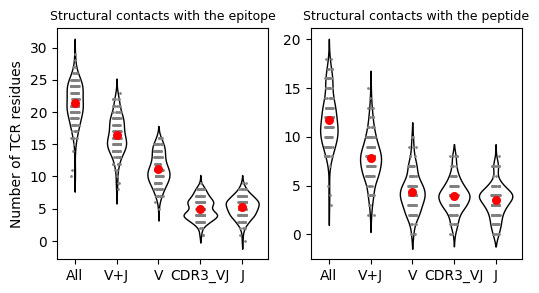

In [320]:
files = ['TableS3A_contact_pMHC_RR.csv', 'TableS3B_contact_pep_RR.csv']

fig, axes = plt.subplots(1,2, figsize=(6,3))

comparisons = [
    ('V+J', 'CDR3_VJ'),
    ('V', 'CDR3_VJ'),
    ('J', 'CDR3_VJ'),
    ('V', 'J')
]

for cnt, file in enumerate(files):
    ax = axes[cnt]

    df = pd.read_csv(file)
    df = df[['PDB', 'TRAV_int', 'TRAJ_int', 'CDR3A_VJ_int', 'TRBV_int', 'TRBJ_int', 'CDR3B_VJ_int']]
    df['All'] = df['TRAV_int'] + df['TRAJ_int'] + df['TRBV_int'] + df['TRBJ_int'] + df['CDR3A_VJ_int'] + df['CDR3B_VJ_int'] 
    df['V+J'] = df['TRAV_int'] + df['TRAJ_int'] + df['TRBV_int'] + df['TRBJ_int']
    df['V'] = df['TRAV_int'] + df['TRBV_int'] 
    df['CDR3_VJ'] = df['CDR3A_VJ_int'] + df['CDR3B_VJ_int'] 
    df['J'] = df['TRAJ_int'] + df['TRBJ_int'] 
    df = df[['All', 'V+J', 'V', 'CDR3_VJ', 'J']]

    df_long = df.melt(var_name="CDR_segment", value_name="Contacts")
    sns.violinplot(x="CDR_segment", y="Contacts", data=df_long, inner=None, color="white", ax=ax)  
    for patch in ax.collections:  # violins are every other collection
        patch.set_edgecolor('black')
        patch.set_linewidth(1)

    sns.stripplot(x="CDR_segment", y="Contacts", data=df_long, color="grey", size=2, jitter=True, ax=ax)

    # Add mean as red dot
    segs = ['All', 'V+J', 'V', 'CDR3_VJ', 'J']

    for i, seg in enumerate(segs):
        tmp = df_long[df_long['CDR_segment'] == seg]
        mean = np.mean(tmp['Contacts'])
        ax.scatter(i, mean, color='red', s=30, zorder=10)

    ax.set_xlabel('')

axes[0].set_ylabel('Number of TCR residues')
axes[1].set_ylabel('')
axes[0].set_title('Structural contacts with the epitope', fontsize=9)
axes[1].set_title('Structural contacts with the peptide', fontsize=9)


array(['1mi5', '2ak4', '3kpr', '3kps', '3uts', '3vxm', '4ftv', '5c07',
       '5c08', '5c09', '5c0a', '5c0b', '5c0c', '5hyj', '5jhd', '6bj2',
       '6rpa', '6tro', '6vqo', '6zkw', '6zkx', '6zkz', '7n2n', '7n2o',
       '7n2s', '7pb2', '7rk7', '8cx4'], dtype=object)